#1-1

MNIST 데이터셋을 사용하여 간단한 VAE을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
# 학습할 에폭 수
num_epochs = 50

# 한 번에 처리할 데이터 샘플(batch)의 크기
batch_size = 100

# 옵티마이저에서 사용할 학습률
learning_rate = 0.0002

# 입력 이미지의 크기
img_size = 28 * 28

# 잠재 공간의 차원
latent_dim = 20

# 첫 번째 은닉층의 크기
hidden_size1 = 256

# 두 번째 은닉층의 크기
hidden_size2 = 512

# 세 번째 은닉층의 크기
hidden_size3 = 1024

# 결과를 저장할 디렉터리 이름
dir_name = "VAE_results"

# CUDA를 사용할 수 있으면 GPU를, 그렇지 않으면 CPU를 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 결과 디렉터리가 존재하지 않으면 새로 생성
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# 데이터 전처리를 위한 변환 설정:
# 1. 이미지를 텐서로 변환
# 2. (0.5,)를 평균으로, (0.5,)를 표준편차로 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [3]:
MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 53142222.19it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2033706.50it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11795743.16it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3675579.54it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [4]:
# 인코더 클래스 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # 입력 이미지 크기를 첫 번째 은닉층의 크기로 변환
        self.fc1 = nn.Linear(img_size, hidden_size3)
        # 첫 번째 은닉층의 출력을 두 번째 은닉층 크기로 변환
        self.fc2 = nn.Linear(hidden_size3, hidden_size2)
        # 두 번째 은닉층의 출력을 세 번째 은닉층 크기로 변환
        self.fc3 = nn.Linear(hidden_size2, hidden_size1)
        # 세 번째 은닉층에서 잠재 변수의 평균값을 출력
        self.fc_mean = nn.Linear(hidden_size1, latent_dim)
        # 세 번째 은닉층에서 잠재 변수의 로그 분산값을 출력
        self.fc_logvar = nn.Linear(hidden_size1, latent_dim)
        # LeakyReLU 활성화 함수 사용 (0.2는 음수 부분의 slope)
        self.leaky_relu = nn.LeakyReLU(0.2)

    # 순전파 함수
    def forward(self, x):
        # 첫 번째, 두 번째, 세 번째 은닉층을 거치면서 LeakyReLU 적용
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        # 잠재 변수의 평균값과 로그 분산값을 계산
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar


# 디코더 클래스 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # 잠재 변수 크기를 첫 번째 은닉층 크기로 변환
        self.fc1 = nn.Linear(latent_dim, hidden_size1)
        # 첫 번째 은닉층의 출력을 두 번째 은닉층 크기로 변환
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # 두 번째 은닉층의 출력을 세 번째 은닉층 크기로 변환
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        # 세 번째 은닉층의 출력을 원래 이미지 크기로 변환
        self.fc4 = nn.Linear(hidden_size3, img_size)
        # ReLU 활성화 함수 사용
        self.relu = nn.ReLU()
        # 출력층에서 Sigmoid 활성화 함수 사용
        self.sigmoid = nn.Sigmoid()

    # 순전파 함수
    def forward(self, x):
        # 첫 번째, 두 번째, 세 번째 은닉층을 거치면서 ReLU 적용
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        # 출력층에서 Sigmoid 적용하여 원래 이미지 복원
        x = self.sigmoid(self.fc4(x))
        return x

# 인코더와 디코더 인스턴스를 생성하고, 사용 가능한 장치로 이동
encoder = Encoder().to(device)
decoder = Decoder().to(device)


In [5]:
# 잠재 변수의 재파라미터화 트릭 함수
def reparameterize(mean, logvar):
    # 로그 분산(logvar)의 절반을 취해 표준편차 계산
    std = torch.exp(0.5 * logvar)
    # 표준 정규 분포에서 랜덤 노이즈를 샘플링
    eps = torch.randn_like(std)
    # 잠재 변수 z를 생성 (z = mean + eps * std)
    return mean + eps * std

# 손실 함수 정의
# 재구성 손실(BCE)와 KLD 손실을 더해 최종 손실을 계산
def loss_function(recon_x, x, mean, logvar):
    # BCE: 입력 이미지(x)와 재구성된 이미지(recon_x) 간의 이진 교차 엔트로피 손실
    # reduction='sum'은 모든 픽셀에 대해 손실 값을 더함
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KLD: 잠재 변수 분포를 정규분포로 만드는 Kullback-Leibler divergence 손실
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # 재구성 손실(BCE)과 KLD 손실을 더한 값이 최종 손실
    return BCE + KLD

# 인코더와 디코더의 파라미터를 포함한 Adam 옵티마이저 설정
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)


In [6]:
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0

    for images, _ in data_loader:
        images = images.view(-1, img_size).to(device)

        images = (images + 1) / 2

        optimizer.zero_grad()

        mean, logvar = encoder(images)
        z = reparameterize(mean, logvar)
        recon_images = decoder(z)

        loss = loss_function(recon_images, images, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(data_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    with torch.no_grad():
        z = torch.randn(batch_size, latent_dim).to(device)
        sample = decoder(z).view(-1, 1, 28, 28)
        save_image(sample, os.path.join(dir_name, f'VAE_fake_image_{epoch + 1}.png'))

Epoch [1/50], Loss: 200.6192
Epoch [2/50], Loss: 148.9053
Epoch [3/50], Loss: 131.4930
Epoch [4/50], Loss: 124.9280
Epoch [5/50], Loss: 120.6948
Epoch [6/50], Loss: 116.8540
Epoch [7/50], Loss: 113.9670
Epoch [8/50], Loss: 111.8440
Epoch [9/50], Loss: 110.3047
Epoch [10/50], Loss: 109.0334
Epoch [11/50], Loss: 108.0159
Epoch [12/50], Loss: 107.0295
Epoch [13/50], Loss: 106.2015
Epoch [14/50], Loss: 105.4502
Epoch [15/50], Loss: 104.7880
Epoch [16/50], Loss: 104.1910
Epoch [17/50], Loss: 103.6710
Epoch [18/50], Loss: 103.1278
Epoch [19/50], Loss: 102.6394
Epoch [20/50], Loss: 102.1793
Epoch [21/50], Loss: 101.7258
Epoch [22/50], Loss: 101.2680
Epoch [23/50], Loss: 100.8786
Epoch [24/50], Loss: 100.5116
Epoch [25/50], Loss: 100.1672
Epoch [26/50], Loss: 99.8203
Epoch [27/50], Loss: 99.5386
Epoch [28/50], Loss: 99.2334
Epoch [29/50], Loss: 98.9967
Epoch [30/50], Loss: 98.7734
Epoch [31/50], Loss: 98.4979
Epoch [32/50], Loss: 98.2441
Epoch [33/50], Loss: 98.0150
Epoch [34/50], Loss: 97.780

#1-2

아래 마크다운으로 VAE_fake_image_1.png와 VAE_fake_image_50.png를 함께 첨부해주세요.

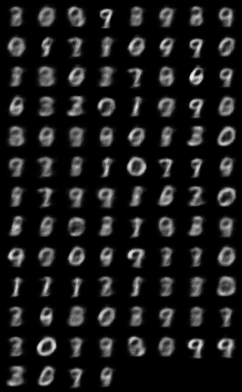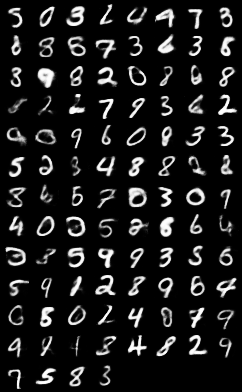